In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from astropy.io import fits

# josh's frankenz
import frankenz as fz

%matplotlib inline

# Catalog Setup

In [3]:
f = '/Users/josephwick/Documents/College/Merian/SOM/COSMOS2015_r23.6_SOM_v2.fits'

In [4]:
# load train data
# yifei's catalog with specz flag ('spec_z' == 1)
# We train on the spectroscopic subset of the entire, representative, catalog

data=fits.open(f)[1].data
data = data[data['z_type']==1]

# extract flux
# we're using g,r,i,z,y band magnitudes
aphot_train = 10**(-0.4 * np.c_[data['a_g'], data['a_r'], data['a_i'], 
                                data['a_z'], data['a_y']])

phot_train = np.c_[data['g_cmodel_flux'], 
                   data['r_cmodel_flux'],
                   data['i_cmodel_flux'],
                   data['z_cmodel_flux'],
                   data['y_cmodel_flux']] / aphot_train

err_train = np.c_[data['g_cmodel_flux_err'], 
                  data['r_cmodel_flux_err'], 
                  data['i_cmodel_flux_err'],
                  data['z_cmodel_flux_err'],
                  data['y_cmodel_flux_err']] / aphot_train

mask_train = (err_train > 0.) & np.isfinite(err_train) & np.isfinite(phot_train)

# remove any sources with non-detections
sel = mask_train.sum(axis=1) == 5
phot_train, err_train, mask_train = phot_train[sel], err_train[sel], mask_train[sel]

/Users/josephwick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


In [5]:
# load calib data
# yifei's catalog, representative
# we want to calibrate the specz subset to the representative catalog

data=fits.open(f)[1].data

aphot_calib = 10**(-0.4 * np.c_[data['a_g'], data['a_r'], data['a_i'], 
                                data['a_z'], data['a_y']])

phot_calib = np.c_[data['g_cmodel_flux'],
                   data['r_cmodel_flux'],
                   data['i_cmodel_flux'],
                   data['z_cmodel_flux'],
                   data['y_cmodel_flux']] / aphot_calib

err_calib = np.c_[data['g_cmodel_flux_err'],
                  data['r_cmodel_flux_err'],
                  data['i_cmodel_flux_err'],
                  data['z_cmodel_flux_err'],
                  data['y_cmodel_flux_err']] / aphot_calib

mask_calib = (err_calib > 0.) & np.isfinite(err_calib) & np.isfinite(phot_calib)

# remove any sources with non-detections
sel2 = mask_calib.sum(axis=1) == 5
phot_calib, err_calib, mask_calib = phot_calib[sel2], err_calib[sel2], mask_calib[sel2]

/Users/josephwick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


In [6]:
skynoise = np.median(err_calib, axis=0)
# josh used the calibration set for this

zeropoint = 10**(-0.4 * 48.6)
# unsure where these values come from
# = 3.6e-20

# Weights

In [7]:
np.random.seed(2018)
# initialize fitting object
from frankenz.fitting import NearestNeighbors

# initialize NN object
NN = NearestNeighbors(phot_train, err_train, mask_train,
                      feature_map='luptitude', K=25, 
                      fmap_args=[skynoise, zeropoint])

25/25 KDTrees constructed


In [8]:
np.random.seed(58372)

In [9]:
saveas = 'specz-weights.npy'

In [10]:
# generate calibration weights

# fit calibration objects
NN.fit(phot_calib, np.sqrt(err_calib**2 + (0.02*phot_calib)**2), 
       mask_calib, k=10, lprob_kwargs={'dim_prior': False})

# get calibration weights from predictions
from scipy.special import logsumexp
Ntrain, Ncalib = len(phot_train), len(phot_calib)
calib_wts = np.zeros(Ntrain)
for i in range(Ncalib):
    n = NN.Nneighbors[i]
    idxs = NN.neighbors[i, :n]
    logwts = NN.fit_lnprob[i, :n]
    wts = np.exp(logwts - logsumexp(logwts))
    calib_wts[idxs] += wts
calib_wts *= float(Ntrain) / Ncalib

np.save(saveas, calib_wts)

Fitting object 99411/99411


In [11]:
wts = np.load(saveas)
# objets that get used more have larger weight

# Plotting Magnitude and Weight

In [12]:
# I used r here because it has the cleanest cutoff at 23.6 of all the bands
# plots are virtually identical across bands
data=fits.open(f)[1].data
rBand = data['r_cmodel_mag']
rBand = rBand[data['z_type']==1]
rBand = rBand[sel]

Text(0, 0.5, 'assigned weight')

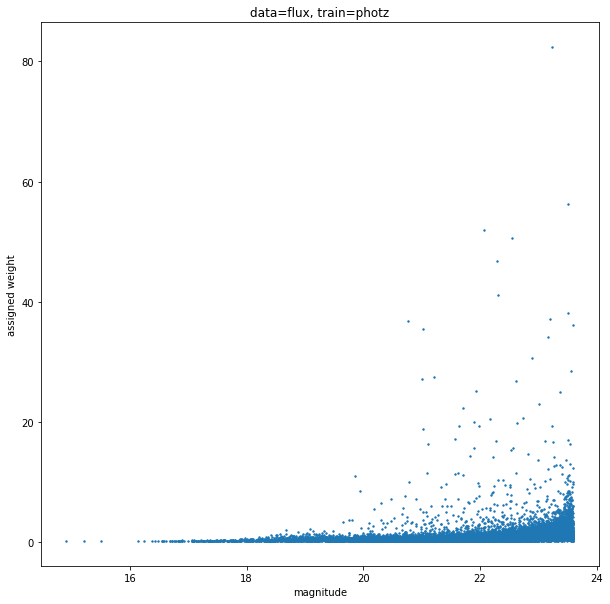

In [13]:
# plotting magnitude vs weight
# we expect galaxies that get used more to have higher weights

fig = plt.figure(figsize=(10,10))
plt.scatter(rBand, wts, s=2)

plt.title('data=flux, train=photz')
plt.xlabel('magnitude')
plt.ylabel('assigned weight')

#plt.savefig('Magnitude vs Weight', format='pdf', dpi='figure')